# Matrice de Coulomb

 Root Mean Squared Error: 0.8117


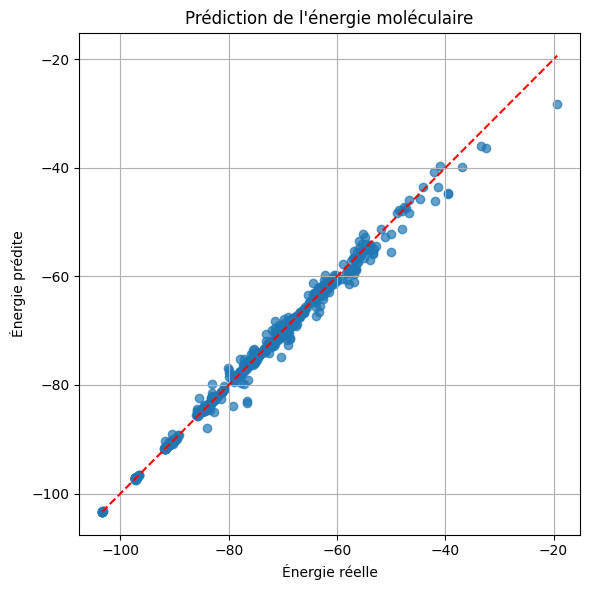

In [5]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Paramètre : nombre maximum d'atomes autorisé (taille max des matrices de Coulomb)
MAX_ATOMS = 30

# Table des nombres atomiques (Z)
ATOMIC_NUMBERS = {
    "H": 1,
    "He": 2,
    "Li": 3,
    "Be": 4,
    "B": 5,
    "C": 6,
    "N": 7,
    "O": 8,
    "F": 9,
    "Ne": 10,
    "Na": 11,
    "Mg": 12,
    "Al": 13,
    "Si": 14,
    "P": 15,
    "S": 16,
    "Cl": 17,
    "Ar": 18,
    # Ajouter plus si besoin
}

# Fonction pour lire un fichier .xyz
def read_xyz(file_path):
    atoms = []
    positions = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        num_atoms = int(lines[0].strip())
        for line in lines[2:2 + num_atoms]:
            parts = line.split()
            atom = parts[0]
            position = np.array([float(x) for x in parts[1:4]])
            atoms.append(atom)
            positions.append(position)
    return atoms, np.array(positions)

# Fonction pour calculer la matrice de Coulomb
def compute_coulomb_matrix(positions, atoms):
    num_atoms = len(atoms)
    Z = [ATOMIC_NUMBERS.get(atom, 0) for atom in atoms]  # Obtenir Z pour chaque atome
    coulomb_matrix = np.zeros((num_atoms, num_atoms))
    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                coulomb_matrix[i, j] = 0.5 * Z[i] ** 2.4
            else:
                dist = np.linalg.norm(positions[i] - positions[j])
                coulomb_matrix[i, j] = (Z[i] * Z[j]) / dist if dist != 0 else 0.0
    return coulomb_matrix

# Padding des matrices à taille fixe
def pad_coulomb_matrix(matrix, max_atoms):
    padded = np.zeros((max_atoms, max_atoms))
    size = matrix.shape[0]
    padded[:size, :size] = matrix
    return padded

# Lecture des données + association aux énergies
def prepare_data_from_directory(xyz_directory, energy_file):
    energy_df = pd.read_csv(energy_file)
    energy_dict = dict(zip(energy_df['id'], energy_df['energy']))

    X = []
    y = []

    xyz_files = [f for f in os.listdir(xyz_directory) if f.endswith('.xyz')]

    for file in xyz_files:
        try:
            # Extraire l'ID de type id_123.xyz -> 123
            molecule_id = int(file.split('_')[1].split('.')[0])
        except (IndexError, ValueError):
            print(f"Nom de fichier inattendu : {file}")
            continue

        if molecule_id in energy_dict:
            file_path = os.path.join(xyz_directory, file)
            atoms, positions = read_xyz(file_path)
            coulomb_matrix = compute_coulomb_matrix(positions, atoms)
            padded_matrix = pad_coulomb_matrix(coulomb_matrix, MAX_ATOMS)
            X.append(padded_matrix.flatten())
            y.append(energy_dict[molecule_id])
        else:
            print(f"Aucune énergie trouvée pour {file} (ID {molecule_id})")

    return np.array(X), np.array(y)

# === Chemins vers les fichiers ===
xyz_directory = '/home/gris/N7/Semestre_10/App_cont_phys/Projet_Molecules/data/atoms/train'
energy_file = '/home/gris/N7/Semestre_10/App_cont_phys/Projet_Molecules/data/energies/train.csv'

# Préparation des données
X, y = prepare_data_from_directory(xyz_directory, energy_file)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement modèle de régression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédiction + évaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f' Root Mean Squared Error: {rmse:.4f}')

# Affichage des résultats
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Énergie réelle')
plt.ylabel('Énergie prédite')
plt.title('Prédiction de l\'énergie moléculaire')
plt.grid(True)
plt.tight_layout()
plt.show()


Linear Regression: Root Mean Squared Error = 1.7456


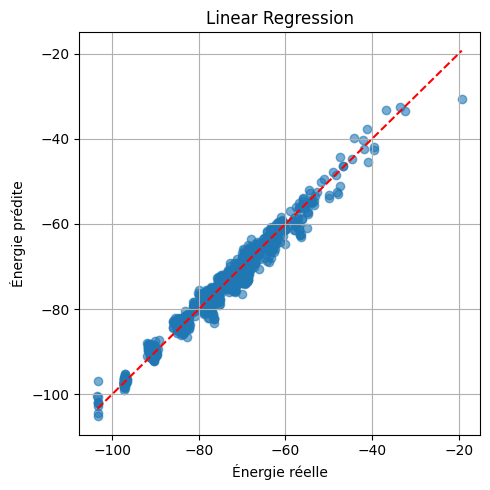

Ridge Regression: Root Mean Squared Error = 1.8694


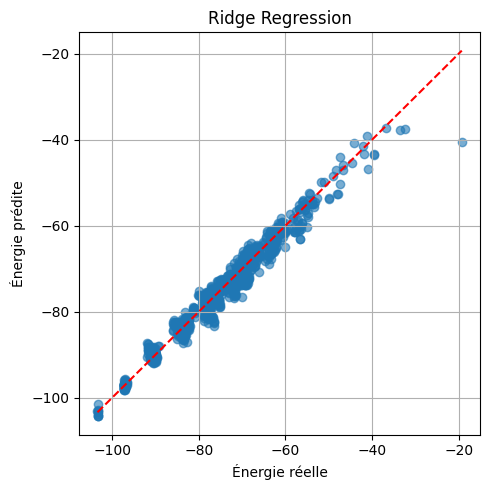

Random Forest: Root Mean Squared Error = 0.8117


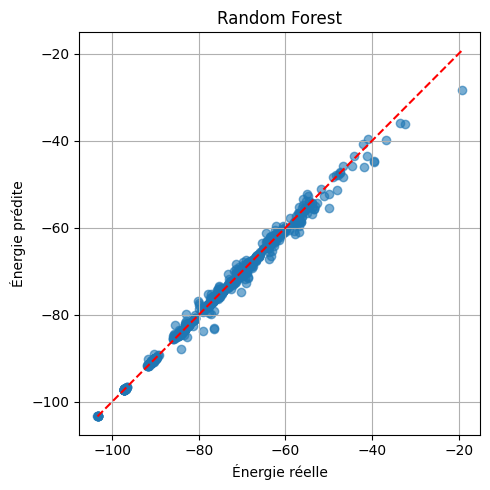

KNN Regressor: Root Mean Squared Error = 2.0409


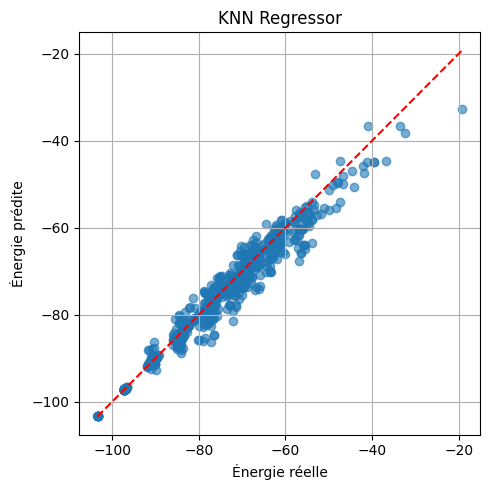

SVR: Root Mean Squared Error = 3.2152


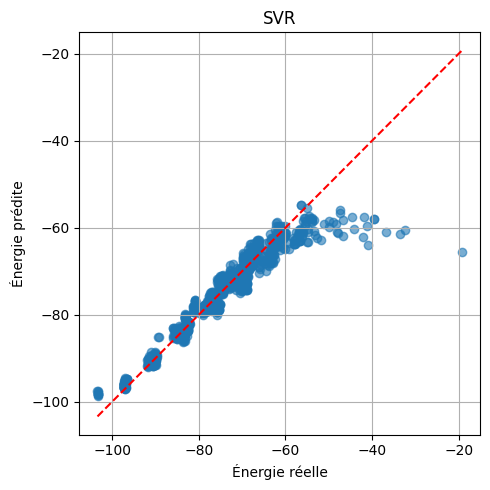

MLP Regressor: Root Mean Squared Error = 1.9951


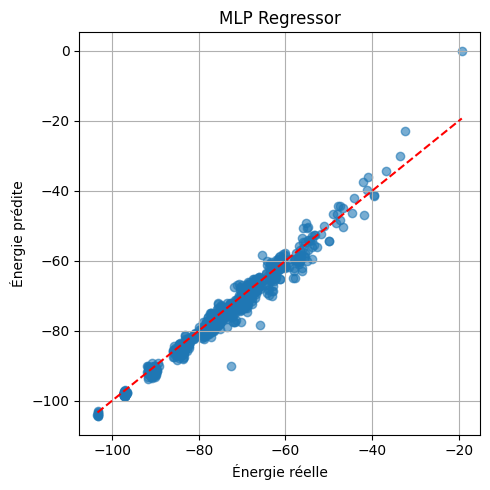

In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des modèles à tester
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Entraînement, prédiction et évaluation pour chaque modèle
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{name}: Root Mean Squared Error = {rmse:.4f}')
    
    # Affichage des résultats
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Énergie réelle')
    plt.ylabel('Énergie prédite')
    plt.title(f'{name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Ridge Regression (alpha=0.0001): RMSE = 1.7335
Ridge Regression (alpha=0.0003): RMSE = 1.7337
Ridge Regression (alpha=0.0008): RMSE = 1.7346
Ridge Regression (alpha=0.0022): RMSE = 1.7364
Ridge Regression (alpha=0.0060): RMSE = 1.7385
Ridge Regression (alpha=0.0167): RMSE = 1.7406
Ridge Regression (alpha=0.0464): RMSE = 1.7435
Ridge Regression (alpha=0.1292): RMSE = 1.7518
Ridge Regression (alpha=0.3594): RMSE = 1.7818
Ridge Regression (alpha=1.0000): RMSE = 1.8694


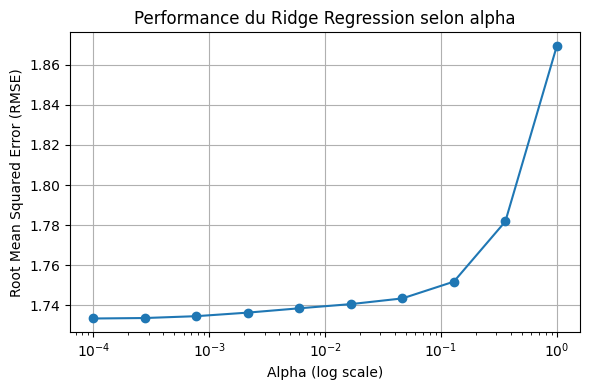

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Liste des alpha à tester (logarithmiquement espacés)
alphas = np.logspace(-4, 0, 10)  # 10 valeurs entre 1e-4 et 1

# Stocker les résultats
rmse_values = []

# Boucle sur les différents alpha
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    print(f'Ridge Regression (alpha={alpha:.4f}): RMSE = {rmse:.4f}')

# Tracer l'évolution de la RMSE en fonction de alpha
plt.figure(figsize=(6, 4))
plt.plot(alphas, rmse_values, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Performance du Ridge Regression selon alpha')
plt.grid(True)
plt.tight_layout()
plt.show()
